In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re
import fileinput

The idea of the scritp is to us the mapping data of
nucmer v81_cns_p_ctg.fa v91_cns_p_ctg.fa > out.delta
delta-filter -r -q out.delta > v91_cns_p_on_v81_cns_p_qrfiltered.delta
show-coords -T v91_cns_p_on_v81_cns_p_qrfiltered.delta > v91_cns_p_on_v81_cns_p.qrcoords


In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }


In [3]:
#THIS script still needs to be fixed for the cases where mummer alignment ends overlap

In [19]:
#define working directory
file_path = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer"
pwoh_fn = "v8_1_ph_tr_ctg_pwoh_ctg.fa"
pwoh_rn_g_fn = "v8_1_ph_tr_ctg_pwoh_ctg_rng.fa" #for the rename with -g in mummer
pwoh_rn_r_fn = "v8_1_ph_tr_ctg_pwoh_ctg_rng.fa" # for rename with -r in mummer
h_above_200_fn = 'v8_1_ph_tr_ctg_h_ctg_plus_200.fa'
p_above_200_fn ='v8_1_ph_tr_ctg_p_ctg_plus_200.fa'
h_fn = 'v8_1_ph_tr_ctg_h_ctg.fa'

In [20]:
#write a bash script that maps all pwoh on p with h using the '-r' option
pwoh_fn = 'v8_1_ph_tr_ctg_pwoh_ctg.fa' #file that contains all pwoh
pwh_contigs_fn = 'v8_1_ph_tr_ctg_pwh_ctg.fa' #file that contains all pwh

In [7]:
os.chdir(file_path)

In [9]:
#initiate nucmer bash script writting
bash_script="v8_1_ph_p_on_p_rnucmer.sh"
outf = open(bash_script, 'w')
outf.write('#!/bin/bash\n')
for seq in SeqIO.parse(pwoh_fn, 'fasta'):
        outf.write('nucmer '+pwh_contigs_fn+' '+seq.id+".fa > "+'out.delta\n')
        outf.write('delta-filter -r '+'out.delta'+" > "+seq.id+"_rfiltered.delta\n")
        outf.write('show-coords -T '+seq.id+"_rfiltered.delta > "+seq.id+".rcoords\n")
outf.close()

In [12]:
#get all the .gcoords files
file_handler = os.walk(file_path, topdown=False)
gcoords_files = [x for x in list(file_handler)[-1][2] if x[-7:]== 'gcoords']
pwoh_rn_dic_r ={} #dic for renaming pwoh
#hit_summary_df = pd.DataFrame(columns=['pwoh', 'best hit p', 'pwoh len', '%len hit', '%ID']) #summary dataframe that indicates best hit for each pwoh, 

In [8]:
#make dataframe of initial query file pwoh_fn
handle_1 = open(pwoh_fn)
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
pwoh_df = pd.concat([s1, s2], axis=1)
handle_1.close()

In [13]:
#here pull in each gcoords file and define the longest p_wh hit on each p_woh. Save summary results in new data frame
#and generate renaming dictonary
#rename outfile for hit summary df
name_list = []
len_list=[]
rel_len_list=[]
pc_ID_list=[]
best_hit_list=[]
for x in gcoords_files:
    best_hit = ''
    mummer_df_tmp = ''
    mummer_df_tmp = pd.read_csv(file_path+'/'+x, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-h"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    #till here it reads in the gcoords_files as a dataframe
    best_hit = mummer_df_tmp.groupby('ID-p')['LEN 1'].sum().sort_values().index[-1] #this gets the p_wh that has the highest coverage in length
    best_hit_list.append(best_hit)
    best_df  = mummer_df_tmp[mummer_df_tmp['ID-p'] == best_hit]
    best_df['rel %'] = best_df['LEN 2']*best_df['% IDY']
    pc_ID_list.append(best_df['rel %'].sum()/best_df['LEN 2'].sum())
    #up to here the %_ID is calcuated for the best hit
    name_list.append(x[:-8])
    len_list.append(pwoh_df.loc[pwoh_df['ID']==x[:-8],'Length'].sum())
    rel_len_list.append(best_df['LEN 2'].sum()/pwoh_df.loc[pwoh_df['ID']==x[:-8],'Length'].sum()*100)
    pwoh_rn_dic_g[x[:-8]]=best_hit+'_'+x[:-8]
hit_summary_df_gcoords = pd.concat([pd.Series(name_list), pd.Series(best_hit_list), pd.Series(len_list), pd.Series(rel_len_list), pd.Series(pc_ID_list)],axis=1, keys=['p_woh', 'best hit p_wh', 'p_woh len', '%len hit', '%ID'])
hit_summary_df_gcoords['%len hit'] = hit_summary_df_gcoords['%len hit'].round(2)
hit_summary_df_gcoords['%ID'] = hit_summary_df_gcoords['%ID'].round(2)
hit_summary_df_gcoords.to_csv(file_path+'/v8_1_p_woh_on_p_wh_best_hit_summary_gcoords.csv', index=False)
#pwoh_rn_dic

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
#get all the .gcoords files
file_handler = os.walk(file_path, topdown=False)
rcoords_files = [x for x in list(file_handler)[-1][2] if x[-7:]== 'rcoords']
pwoh_rn_dic_g = {} #dic for renaming pwoh
#hit_summary_df = pd.DataFrame(columns=['pwoh', 'best hit p', 'pwoh len', '%len hit', '%ID']) #summary dataframe that indicates best hit for each pwoh, 

In [40]:
#here pull in each rcoords file and define the longest p_wh hit on each p_woh. Save summary results in new data frame
#and generate renaming dictonary
#rename outfile for hit summary df
name_list = []
len_list=[]
rel_len_list=[]
pc_ID_list=[]
best_hit_list=[]
for x in rcoords_files:
    best_hit = ''
    mummer_df_tmp = ''
    mummer_df_tmp = pd.read_csv(file_path+'/'+x, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-h"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    #till here it reads in the gcoords_files as a dataframe
    best_hit = mummer_df_tmp.groupby('ID-p')['LEN 1'].sum().sort_values().index[-1] #this gets the p_wh that has the highest coverage in length
    best_hit_list.append(best_hit)
    best_df  = mummer_df_tmp[mummer_df_tmp['ID-p'] == best_hit]
    best_df['rel %'] = best_df['LEN 2']*best_df['% IDY']
    pc_ID_list.append(best_df['rel %'].sum()/best_df['LEN 2'].sum())
    #up to here the %_ID is calcuated for the best hit
    name_list.append(x[:-8])
    len_list.append(pwoh_df.loc[pwoh_df['ID']==x[:-8],'Length'].sum())
    rel_len_list.append(best_df['LEN 2'].sum()/pwoh_df.loc[pwoh_df['ID']==x[:-8],'Length'].sum()*100)
    pwoh_rn_dic_r[x[:-8]]=best_hit+'_'+x[:-8]
hit_summary_df_rcoords = pd.concat([pd.Series(name_list), pd.Series(best_hit_list), pd.Series(len_list), pd.Series(rel_len_list), pd.Series(pc_ID_list)],axis=1, keys=['p_woh', 'best hit p_wh', 'p_woh len', '%len hit', '%ID'])
hit_summary_df_rcoords['%len hit'] = hit_summary_df_rcoords['%len hit'].round(2)
hit_summary_df_rcoords['%ID'] = hit_summary_df_rcoords['%ID'].round(2)
hit_summary_df_rcoords.to_csv(file_path+'/v8_1_p_woh_on_p_wh_best_hit_summary_rcoords.csv', index=False)
#pwoh_rn_dic

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
pwoh_rn_dic_r.keys()

dict_keys(['000102F', '000140F', '000111F', '000010F', '000073F', '000234F', '000182F', '000094F', '000143F', '000178F', '000078F', '000096F', '000124F', '000183F', '000189F', '000175F', '000081F', '000107F', '000160F', '000153F', '000174F', '000187F', '000114F', '000098F', '000088F', '000215F', '000152F', '000044F', '000196F', '000226F', '000133F', '000109F', '000110F', '000167F', '000154F', '000162F', '000165F', '000163F', '000155F', '000136F', '000041F', '000159F', '000019F', '000130F', '000150F', '000171F', '000118F', '000123F', '000138F', '000128F', '000166F', '000087F', '000119F', '000116F', '000207F', '000252F', '000221F', '000191F', '000131F', '000134F', '000115F', '000032F', '000141F', '000198F', '000100F', '000142F', '000120F', '000161F', '000067F', '000086F', '000188F', '000125F', '000194F', '000176F', '000122F', '000145F', '000104F', '000227F', '000057F', '000220F', '000068F', '000091F', '000172F', '000099F', '000148F', '000051F', '000225F', '000233F', '000157F', '000103F',

In [45]:
#do a comparison where -r and -g option in mummer give a different mapping result if at all
g_and_r_diff =[]
for g in pwoh_rn_dic_g.keys():
    if pwoh_rn_dic_g[g] != pwoh_rn_dic_r[g]:
            g_and_r_diff.append(g)
            print("This primary contig %s is differently asigned as %s or %s" % (g, pwoh_rn_dic_g[g],pwoh_rn_dic_r[g]))

This primary contig 000073F is differently asigned as 000033F_000073F or 000003F_000073F
This primary contig 000078F is differently asigned as 000043F_000078F or 000000F_000078F
This primary contig 000215F is differently asigned as 000070F_000215F or 000013F_000215F
This primary contig 000152F is differently asigned as 000137F_000152F or 000139F_000152F
This primary contig 000162F is differently asigned as 000173F_000162F or 000126F_000162F
This primary contig 000171F is differently asigned as 000137F_000171F or 000139F_000171F
This primary contig 000116F is differently asigned as 000058F_000116F or 000050F_000116F
This primary contig 000125F is differently asigned as 000054F_000125F or 000048F_000125F
This primary contig 000220F is differently asigned as 000058F_000220F or 000018F_000220F
This primary contig 000172F is differently asigned as 000037F_000172F or 000004F_000172F
This primary contig 000051F is differently asigned as 000013F_000051F or 000000F_000051F
This primary contig 0

In [46]:
hit_summary_df_gcoords.head()

,p_woh,best hit p_wh,p_woh len,%len hit,%ID
0,000010F,000005F,125749,16.17,99.43
1,000019F,000008F,75232,45.34,97.25
2,000025F,000034F,69717,71.06,97.62
3,000032F,000031F,94657,20.46,99.75
4,000041F,000097F,260298,36.37,97.75


In [50]:
for g in g_and_r_diff:
    print(g, hit_summary_df_gcoords[hit_summary_df_gcoords['p_woh']==g]['%len hit'].sum(),hit_summary_df_rcoords[hit_summary_df_rcoords['p_woh']==g]['%len hit'].sum())

000073F 3.86 11.65
000078F 3.89 8.54
000215F 10.75 13.22
000152F 62.69 111.0
000162F 42.55 96.77
000171F 97.37 128.93
000116F 9.45 11.58
000125F 13.0 13.83
000220F 38.64 39.88
000172F 8.62 9.86
000051F 9.49 20.55
000156F 30.4 59.63
000105F 15.18 15.83
000177F 75.87 139.07
000223F 34.05 57.03
000168F 41.35 48.36


In [17]:
#rename p_woh to hs based on rcoords without filter
p_woh_list =[]
for p_woh in SeqIO.parse(pwoh_fn, 'fasta'):
    tmp_id =''
    tmp_seq=''
    tmp_id = pwoh_rn_dic_g[p_woh.id]
    tmp_seq = p_woh.seq
    p_woh_list.append(SeqRecord(tmp_seq, id=tmp_id, description=''))
SeqIO.write(p_woh_list, pwoh_rn_r_fn, 'fasta')
rn_fn = [pwh_contigs_fn, pwoh_rn_r_fn, p_above_200_fn, h_fn  , h_above_200_fn]
with open('v8_1_ph_tr_ctg_rn_rcoords_all.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

In [15]:
#rename p_woh to hs based on gcoords without filter
p_woh_list =[]
for p_woh in SeqIO.parse(pwoh_fn, 'fasta'):
    tmp_id =''
    tmp_seq=''
    tmp_id = pwoh_rn_dic_g[p_woh.id]
    tmp_seq = p_woh.seq
    p_woh_list.append(SeqRecord(tmp_seq, id=tmp_id, description=''))
SeqIO.write(p_woh_list, pwoh_rn_g_fn, 'fasta')
rn_fn = [pwh_contigs_fn, pwoh_rn_g_fn, p_above_200_fn, h_fn  , h_above_200_fn]
with open('v8_1_ph_tr_ctg_rn_gcoords_all.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

113

In [30]:
rn_fn = [pwh_contigs_fn, pwoh_rn_fn, p_above_200_fn, h_fn  , h_above_200_fn]

In [32]:
with open('v8_1_ph_tr_ctg_rn_gcoords_all.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

In [ ]:
SeqRecord

now look at the average mapping of h on p for each h

In [21]:
h_on_p_fp = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer/nucmer_h_on_pwh"
p_and_h_fp = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/'
p_and_h_fn = "v8_1_ph_tr_ctg.fa"


In [22]:
#make dataframe of initial h contigs
handle_2 = open(p_and_h_fp+p_and_h_fn)
h_contigs = SeqIO.parse(handle_2, 'fasta')
h_contig_length = []
h_contig_id =[]
for y in h_contigs:
    if '_' in list(y.id):
        h_contig_id.append(y.id)
        h_contig_length.append(len(y.seq))
s3 = pd.Series(h_contig_id, name='ID')
s4 = pd.Series(h_contig_length, name='Length')
h_df = pd.concat([s3, s4], axis=1)
handle_2.close()

In [23]:
os.chdir(h_on_p_fp)

In [24]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer/nucmer_h_on_pwh


In [25]:
fh_2 = os.walk(h_on_p_fp, topdown=False)
h_gcoords_files = [x for x in list(fh_2)[-1][2] if x[-7:]== 'gcoords']

In [26]:
len(h_gcoords_files)

89

In [27]:
#make a summary data frame that provides the % of mapping hits and % of ID for each h on p_wh mapping
h_len =[]
h_id = []
p_id = []
h_pc_len = []
h_pc_id =[]
# up to here initiate the list that will make the dataframe at the end
for h in h_gcoords_files:
    #read in each mummer gcoords file and make df out of it
    mummer_df_tmp = pd.read_csv(h_on_p_fp+'/'+h, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-h"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    h_ctg_list = list(set(mummer_df_tmp["ID-h"].tolist()))
    #get all h_ctgs for each p_ctg
    for h_sub in h_ctg_list:
        #calculate pc_id and pc_len for each hapolitg aligning to the primary contig
        sub_df = ''
        pc_length = ''
        sub_pc_id =''
        h_id.append(h_sub) #add the id to the list
        sub_df = mummer_df_tmp[mummer_df_tmp['ID-h'] == h_sub] #get the df concerning only the current h_ctg
        sub_df
        p_id.append(sub_df['ID-p'].tolist()[0])
        h_len.append(h_df[h_df['ID'] == h_sub]['Length'].sum())
        h_sub_length = sub_df['LEN 2'].sum() #get the aligned length
        pc_length = h_sub_length/h_df[h_df['ID'] == h_sub]['Length'].sum()*100 #calculate the pc_length
        h_pc_len.append(pc_length)
        sub_df["rel %"] = sub_df['LEN 2']*sub_df['% IDY']
        sub_pc_id = sub_df["rel %"].sum()/h_sub_length #calculate the relative identity
        h_pc_id.append(sub_pc_id)
h_on_p_summary_df = pd.concat([pd.Series(h_id), pd.Series(p_id), pd.Series(h_len), pd.Series(h_pc_len), pd.Series(h_pc_id)],axis=1, keys=['h-ID', 'p-ID', 'h len', '%len h_ctg hit', '%ID h'])
h_on_p_summary_df['%len h_ctg hit'] = h_on_p_summary_df['%len h_ctg hit'].round(2)
h_on_p_summary_df['%ID h'] = h_on_p_summary_df['%ID h'].round(2)
h_on_p_summary_df.to_csv(h_on_p_fp+'/v8_1_h_on_pwh_summary.csv', index=False)

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#all seems to be alright but 000082F_001 didn't align to its primary contig with the given options of cat 
nucmer v8_1_ph_tr_ctg_000082F.fa v8_1_ph_tr_ctg_000082F_a_ctg.fa > out.delta
delta-filter -g out.delta > v8_1_ph_000082Fpap_gfiltered.delta
show-coords -T v8_1_ph_000082Fpap_gfiltered.delta > v8_1_ph_000082Fpap.gcoords
##check what is going on there

set(h_df['ID'].tolist())-set(h_on_p_summary_df['h-ID'].tolist())

h_df[h_df['ID']=='000082F_001']['Length']

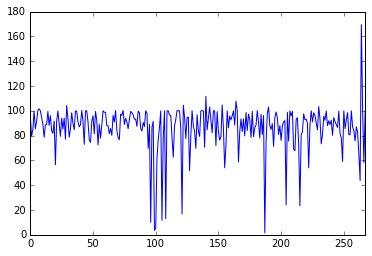

In [16]:
h_on_p_summary_df['%len h_ctg hit'].plot()

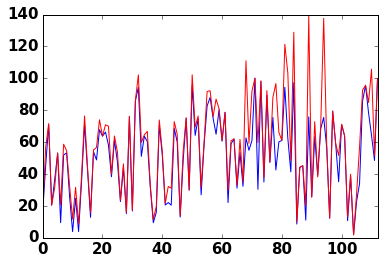

In [29]:
hit_summary_df_gcoords['%len hit'].plot()
hit_summary_df_rcoords['%len hit'].plot(c='r')

(0, 200)

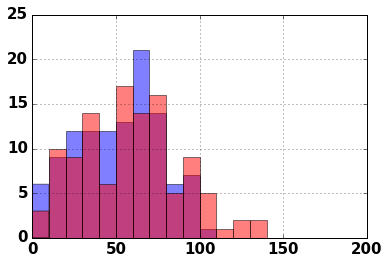

In [32]:
hit_summary_df_gcoords['%len hit'].hist(bins=20, range=(0,200), color='b', alpha=0.5)
hit_summary_df_rcoords['%len hit'].hist(bins=20, range=(0,200), color='r', alpha=0.5)
plt.xlim(0,200)

(0, 200)

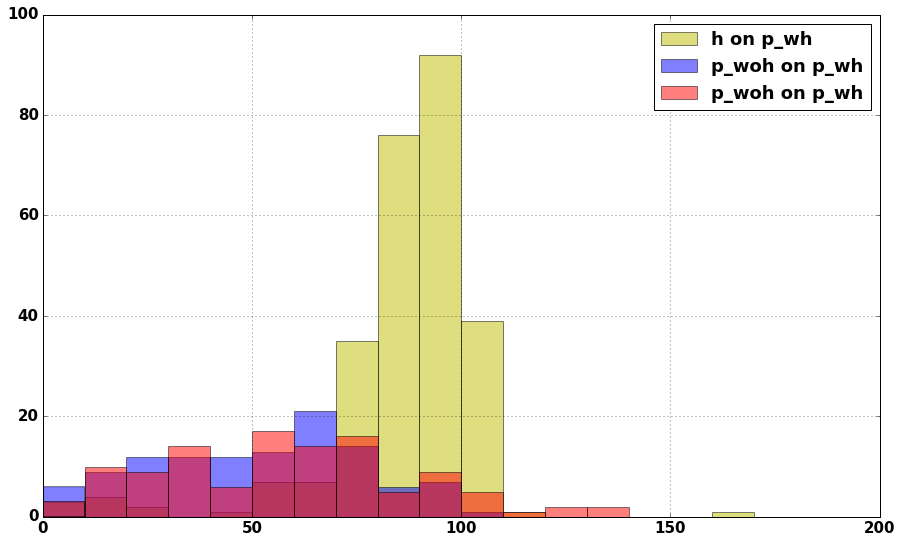

In [34]:
plt.figure(figsize=(15,9))
h_on_p_summary_df['%len h_ctg hit'].hist(bins=20, range=(0,200), color='y',alpha=0.5, label='h on p_wh')
hit_summary_df_gcoords['%len hit'].hist(bins=20, range=(0,200), color='b', alpha=0.5, label='p_woh on p_wh')
hit_summary_df_rcoords['%len hit'].hist(bins=20, range=(0,200), color='r', alpha=0.5, label='p_woh on p_wh')
plt.legend(loc=0)
plt.xlim(0,200)

(0, 100)

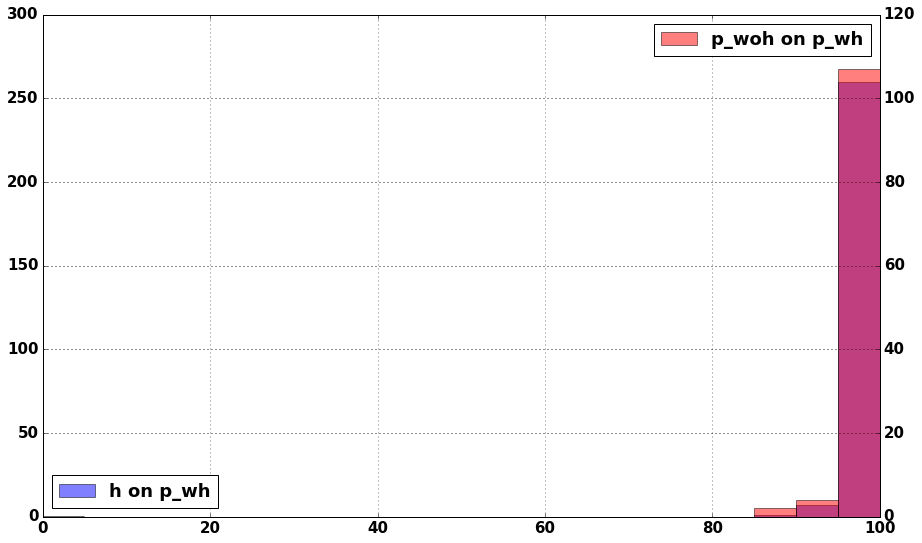

In [60]:
fig, ax1 = plt.subplots(figsize=(15,9))
h_on_p_summary_df['%ID h'].hist(bins=20, range=(0,100), alpha=0.5, label='h on p_wh' )
plt.legend(loc=3)
ax2 = ax1.twinx()
hit_summary_df['%ID'].hist(bins=20, range=(0,100), color='r', alpha=0.5, label='p_woh on p_wh')
plt.legend(loc=0)
plt.xlim(0,100)

In [63]:
h_on_p_summary_df[h_on_p_summary_df['%len h_ctg hit'] < 50]

,h-ID,p-ID,h len,%len h_ctg hit,%ID h
96,000016F_010,000016F,17363,10.01,90.33
99,000016F_006,000016F,13145,3.61,94.95
100,000016F_001,000016F,13656,5.29,91.53
105,000017F_004,000017F,9700,11.66,90.01
108,000017F_007,000017F,8756,12.94,95.30
121,000018F_002,000018F,9677,16.84,88.29
187,000038F_003,000038F,7495,1.60,97.50
204,000049F_002,000049F,9177,24.10,92.80
215,000055F_001,000055F,48197,23.48,92.13
263,000170F_001,000170F,8799,43.78,99.92


In [36]:
h_on_p_summary_df.plot

TypeError: hexbin() missing 2 required positional arguments: 'x' and 'y'

In [61]:
h_on_p_summary_df.head()

,h-ID,p-ID,h len,%len h_ctg hit,%ID h
0,000000F_010,000000F,84607,95.81,98.66
1,000000F_005,000000F,333604,79.68,98.07
2,000000F_008,000000F,193067,84.60,99.22
3,000000F_018,000000F,17417,99.77,98.02
4,000000F_015,000000F,107956,85.48,99.28
